In [1]:
import os

In [2]:
os.chdir('../..')

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import faiss
import torch
from ogb.nodeproppred import DglNodePropPredDataset

Using backend: pytorch


In [4]:
dataset = DglNodePropPredDataset('ogbn-arxiv', root='data/dataset_dgl')
graph = dataset[0][0]

In [5]:
output_emb_file = 'models/deepwalk_03_trvl_embedding.npy'

In [6]:
embeddings = np.load(output_emb_file)
embeddings.shape

(117837, 50)

## Train graph

In [8]:
split_idx = dataset.get_idx_split()
graph_valid = graph.subgraph(
    torch.cat([split_idx['train'], split_idx['valid']]))
graph_valid.add_edges(graph_valid.edges()[1], graph_valid.edges()[0])
mask_tensor = graph_valid.out_degrees() > 0
graph_valid = graph_valid.subgraph(mask_tensor)

## L2 Distance

In [9]:
index = faiss.IndexFlatL2(embeddings.shape[1])

In [10]:
index.train(embeddings)
index.add(embeddings)

In [11]:
index

<faiss.swigfaiss.IndexFlatL2; proxy of <Swig Object of type 'faiss::IndexFlatL2 *' at 0x7ff1b84a1510> >

In [12]:
index.ntotal

117837

### Check if the closest embedding is a neighbor

In [13]:
distances, indices = index.search(embeddings, 2)

In [14]:
graph_valid.has_edges_between(indices[:, 0], indices[:, 1]).sum()

tensor(74365)

In [15]:
graph_valid.has_edges_between(indices[:, 0], indices[:, 1]).all()

tensor(False)

### Check if there is a neighbor in the n closest embeddings

In [16]:
max_k = 100
distances, indices = index.search(embeddings, max_k + 1)

In [17]:
has_neighbor = torch.zeros((embeddings.shape[0], max_k))
for j in range(max_k):
    if j == 0:
        has_neighbor[:, j] = graph_valid.has_edges_between(indices[:, 0], indices[:, j + 1])
    else:
        has_neighbor[:, j] = torch.max(
            has_neighbor[:, j - 1],
            graph_valid.has_edges_between(indices[:, 0], indices[:, j + 1]))

In [18]:
has_neighbor

tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 1., 1., 1.],
        ...,
        [0., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [0., 1., 1.,  ..., 1., 1., 1.]])

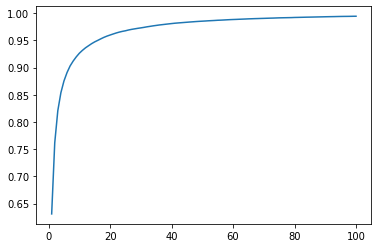

In [19]:
percentages = has_neighbor.sum(dim=0) / embeddings.shape[0]
plt.plot(list(range(1, max_k + 1)), percentages)

In [20]:
percentages

tensor([0.6311, 0.7618, 0.8209, 0.8538, 0.8754, 0.8909, 0.9030, 0.9120, 0.9197,
        0.9263, 0.9316, 0.9363, 0.9402, 0.9440, 0.9472, 0.9500, 0.9529, 0.9555,
        0.9578, 0.9598, 0.9617, 0.9636, 0.9652, 0.9665, 0.9676, 0.9691, 0.9702,
        0.9712, 0.9721, 0.9730, 0.9739, 0.9749, 0.9758, 0.9767, 0.9775, 0.9783,
        0.9789, 0.9796, 0.9802, 0.9809, 0.9815, 0.9820, 0.9824, 0.9829, 0.9833,
        0.9838, 0.9842, 0.9846, 0.9850, 0.9853, 0.9856, 0.9860, 0.9863, 0.9866,
        0.9869, 0.9872, 0.9875, 0.9878, 0.9881, 0.9883, 0.9885, 0.9888, 0.9890,
        0.9893, 0.9895, 0.9897, 0.9899, 0.9901, 0.9903, 0.9904, 0.9906, 0.9908,
        0.9910, 0.9912, 0.9914, 0.9915, 0.9916, 0.9917, 0.9919, 0.9921, 0.9922,
        0.9923, 0.9925, 0.9926, 0.9927, 0.9928, 0.9930, 0.9931, 0.9932, 0.9934,
        0.9935, 0.9936, 0.9937, 0.9938, 0.9939, 0.9940, 0.9941, 0.9942, 0.9943,
        0.9943])

In [21]:
percentages.max()

tensor(0.9943)

## Cossine Distance

In [22]:
emb_norm = embeddings / np.linalg.norm(embeddings, axis=1)[:, None]

In [23]:
index_cos = faiss.IndexFlatIP(emb_norm.shape[1])

In [24]:
index_cos.train(emb_norm)
index_cos.add(emb_norm)

In [25]:
index_cos

<faiss.swigfaiss.IndexFlatIP; proxy of <Swig Object of type 'faiss::IndexFlatIP *' at 0x7ff0b048ed50> >

In [26]:
index_cos.ntotal

117837

### Check if the closest embedding is a neighbor

In [27]:
distances, indices = index_cos.search(emb_norm, 2)

In [28]:
graph_valid.has_edges_between(indices[:, 0], indices[:, 1]).sum()

tensor(74614)

In [29]:
graph_valid.has_edges_between(indices[:, 0], indices[:, 1]).all()

tensor(False)

### Check if there is a neighbor in the n closest embeddings

In [30]:
max_k = 100
distances, indices = index.search(emb_norm, max_k + 1)

In [31]:
has_neighbor = torch.zeros((emb_norm.shape[0], max_k))
for j in range(max_k):
    if j == 0:
        has_neighbor[:, j] = graph_valid.has_edges_between(indices[:, 0], indices[:, j + 1])
    else:
        has_neighbor[:, j] = torch.max(
            has_neighbor[:, j - 1],
            graph_valid.has_edges_between(indices[:, 0], indices[:, j + 1]))

In [32]:
has_neighbor

tensor([[0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 1.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.]])

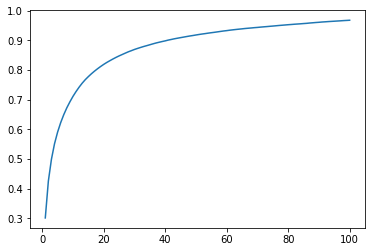

In [33]:
percentages = has_neighbor.sum(dim=0) / embeddings.shape[0]
plt.plot(list(range(1, max_k + 1)), percentages)

In [34]:
percentages

tensor([0.3008, 0.4253, 0.4988, 0.5510, 0.5902, 0.6221, 0.6489, 0.6723, 0.6924,
        0.7108, 0.7271, 0.7420, 0.7554, 0.7672, 0.7775, 0.7872, 0.7960, 0.8041,
        0.8117, 0.8188, 0.8253, 0.8312, 0.8370, 0.8424, 0.8475, 0.8521, 0.8567,
        0.8612, 0.8651, 0.8692, 0.8727, 0.8760, 0.8792, 0.8821, 0.8851, 0.8881,
        0.8910, 0.8935, 0.8959, 0.8982, 0.9008, 0.9030, 0.9053, 0.9072, 0.9091,
        0.9109, 0.9128, 0.9147, 0.9162, 0.9180, 0.9197, 0.9213, 0.9227, 0.9243,
        0.9257, 0.9271, 0.9285, 0.9301, 0.9315, 0.9328, 0.9342, 0.9354, 0.9366,
        0.9377, 0.9387, 0.9399, 0.9408, 0.9417, 0.9428, 0.9436, 0.9446, 0.9455,
        0.9463, 0.9473, 0.9482, 0.9491, 0.9501, 0.9509, 0.9518, 0.9527, 0.9535,
        0.9543, 0.9550, 0.9558, 0.9566, 0.9573, 0.9584, 0.9592, 0.9601, 0.9609,
        0.9618, 0.9625, 0.9632, 0.9639, 0.9645, 0.9652, 0.9658, 0.9666, 0.9672,
        0.9678])